In [1]:
import os
import re
import math
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.spatial import ConvexHull
from skcriteria import Data, MAX
from skcriteria.madm.closeness import TOPSIS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [72]:
DATA_PATH = Path('data')
RESULTS_PATH = DATA_PATH / 'results'
META_FEATURES_PATH = DATA_PATH / 'meta_features'
BASE_RECOMMENDATIONS_PATH = DATA_PATH / 'base_recommendations'
OUTPUT_PATH = Path('output', 'handcraft')

In [73]:
os.makedirs(RECOMMENDATIONS_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [4]:
results_dfs = {}
for filename in os.listdir(RESULTS_PATH):
    archtecture = re.search(r'(?<=results_).*(?=.csv)', filename).group()
    results_dfs[archtecture] = pd.read_csv(RESULTS_PATH / filename)

In [5]:
results_df = pd.concat(results_dfs.values(), ignore_index=True)

In [6]:
results_df.head()

,Architecture,Task,Accuracy_vector,Precision_vector,Recall_vector,F1_vector,Accuracy_avg,Precision_avg,Recall_avg,F1_avg
0,ResNet10,airplane-automobile,"[0.942, 0.939, 0.93, 0.9275, 0.916, 0.9315, 0....","[0.9203510204081633, 0.9051657032755298, 0.893...","[0.932, 0.958, 0.948, 0.939, 0.954, 0.938, 0.8...","[0.9414141414141414, 0.9401373895976447, 0.931...",0.92505,0.892683,0.9274,0.925149
1,ResNet10,airplane-bird,"[0.89, 0.889, 0.8935, 0.882, 0.875, 0.8895, 0....","[0.8614113785557986, 0.8492249488752557, 0.852...","[0.847, 0.878, 0.89, 0.886, 0.888, 0.89, 0.887...","[0.8850574712643677, 0.8877654196157735, 0.893...",0.88480,0.843588,0.8753,0.883662
2,ResNet10,airplane-cat,"[0.9245, 0.9325, 0.935, 0.926, 0.932, 0.925, 0...","[0.8897871921182265, 0.8980344995140912, 0.905...","[0.932, 0.947, 0.937, 0.938, 0.961, 0.909, 0.8...","[0.9250620347394541, 0.933464760965993, 0.9351...",0.92580,0.893557,0.9279,0.925876
3,ResNet10,airplane-deer,"[0.9475, 0.9125, 0.943, 0.93, 0.917, 0.936, 0....","[0.9234072781655036, 0.8553790534618757, 0.921...","[0.949, 0.983, 0.933, 0.98, 0.935, 0.928, 0.95...","[0.947578632051922, 0.9182624941616068, 0.9424...",0.93320,0.900529,0.9460,0.934192
4,ResNet10,airplane-dog,"[0.948, 0.9515, 0.936, 0.947, 0.9345, 0.9475, ...","[0.924704, 0.9361238390092881, 0.9224043010752...","[0.948, 0.936, 0.901, 0.95, 0.914, 0.93, 0.955...","[0.948, 0.9507364144235654, 0.9336787564766839...",0.94470,0.923633,0.9363,0.944177


In [7]:
TASKS = results_df['Task'].unique()
ARCHITECTURES = results_df['Architecture'].unique()

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(ARCHITECTURES)

LabelEncoder()

In [9]:
leave_one_out = LeaveOneOut()

In [10]:
metrics_avg = {}
metrics_vectors = {}
for task in TASKS:
    df = results_df.query(f'Task == "{task}"')
    metrics_avg[task] = {}
    metrics_vectors[task] = {}
    for _, row in df.iterrows():
        metrics_avg[task][row['Architecture']] = {
            'accuracy': row['Accuracy_avg'],
            'precision': row['Precision_avg'],
            'recall': row['Recall_avg'],
            'f1': row['F1_avg']
        }
        metrics_vectors[task][row['Architecture']] = {
            'accuracy': np.array(eval(row['Accuracy_vector'])),
            'precision': np.array(eval(row['Precision_vector'])),
            'recall': np.array(eval(row['Recall_vector'])),
            'f1': np.array(eval(row['F1_vector']))
        }

In [11]:
ranking_architectures = {}
for task in TASKS:
    metrics_columns = ['Accuracy_avg', 'Precision_avg', 'Recall_avg', 'F1_avg']
    metrics_df = results_df.query(f'Task == "{task}"')[metrics_columns]
    data = Data(metrics_df.to_numpy(), criteria=[MAX, MAX, MAX, MAX])
    topsis = TOPSIS()
    ranking_architectures[task] = results_df.iloc[
        metrics_df.index[np.argsort(topsis.decide(data).rank_)]
    ]['Architecture'].tolist()

In [12]:
best_architectures = [
    ranking_architectures[task][0]
    for task in TASKS
]

In [13]:
y = label_encoder.transform(best_architectures)

In [14]:
def load_meta_features(feature_extractor_name: str) -> np.ndarray:
    meta_features = []
    for task in TASKS:
        filename = task + '.pkl'
        with open(META_FEATURES_PATH / feature_extractor_name / filename, 'rb') as f:
            meta_features.append(pickle.load(f))
    return np.array(meta_features)

In [15]:
handcraft_X = load_meta_features('handcraft')

In [17]:
def make_dataset_map_plot(X, y):

    def encircle(i, j, ax=None, **kw):
        if not ax:
            ax = plt.gca()
        p = np.c_[i, j]
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices, :], **kw)
        ax.add_patch(poly)

    lda = LinearDiscriminantAnalysis(n_components=2)

    component_x, component_y = lda.fit_transform(X, y).T

    g = sns.scatterplot(component_x, component_y, hue=y, style=y)
    g.legend(fontsize='x-small', frameon=False)

    for label, color in zip(np.unique(y), ('r', 'g', 'y', 'b')):
        index = np.where(label == pd.Series(y))
        encircle(
            component_x[index],
            component_y[index],
            ec=color,
            fc=color,
            alpha=0.15
        )

    plt.savefig(OUTPUT_PATH / 'datasets_map.png', dpi=1200, bbox_inches='tight')
    plt.show()

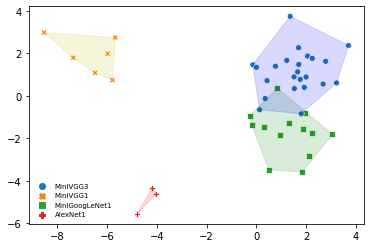

In [18]:
make_dataset_map_plot(handcraft_X, best_architectures)

In [19]:
%%time

gt_recommendations = dict(zip(TASKS, best_architectures))

CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 26.7 µs


In [20]:
%%time

handcraft_rf_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = RandomForestClassifier()
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_rf_recommendations[task] = recommended_architecture

CPU times: user 8.08 s, sys: 2.75 ms, total: 8.08 s
Wall time: 8.1 s


In [22]:
%%time

handcraft_knn_recommendations = {}
for train_index, test_index in leave_one_out.split(TASKS):
    clf = KNeighborsClassifier(n_neighbors=4)
    clf.fit(handcraft_X[train_index], y[train_index])
    task = TASKS[test_index[0]]
    recommended_architecture = label_encoder.inverse_transform(
        clf.predict(handcraft_X[test_index])
    )[0]
    handcraft_knn_recommendations[task] = recommended_architecture

CPU times: user 67.6 ms, sys: 7.73 ms, total: 75.3 ms
Wall time: 75.7 ms


In [24]:
%%time

oner_recommendations = []
for _ in range(10):
    recommended_architecture = random.choice(ARCHITECTURES)
    oner_recommendations.append({
        task: recommended_architecture
        for task in TASKS
    })

CPU times: user 108 µs, sys: 0 ns, total: 108 µs
Wall time: 112 µs


In [25]:
%%time

random_recommendations = []
for _ in range(10):
    random_recommendations.append({
        task: random.choice(ARCHITECTURES)
        for task in TASKS
    })

CPU times: user 694 µs, sys: 0 ns, total: 694 µs
Wall time: 704 µs


In [75]:
with open(BASE_RECOMMENDATIONS_PATH / 'gt.pkl', 'wb') as f:
    pickle.dump(gt_recommendations, f)

In [76]:
with open(BASE_RECOMMENDATIONS_PATH / 'handcraft_rf.pkl', 'wb') as f:
    pickle.dump(handcraft_rf_recommendations, f)

In [77]:
with open(BASE_RECOMMENDATIONS_PATH / 'handcraft_knn.pkl', 'wb') as f:
    pickle.dump(handcraft_knn_recommendations, f)

In [78]:
with open(BASE_RECOMMENDATIONS_PATH / 'oner.pkl', 'wb') as f:
    pickle.dump(oner_recommendations, f)

In [79]:
with open(BASE_RECOMMENDATIONS_PATH / 'random.pkl', 'wb') as f:
    pickle.dump(random_recommendations, f)